# MNIST Classification with MLP -- Low Level API (tf.nn) --
In this notebook, I describe how to implement MLP using tf.nn API.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tensorflow version:  1.15.2
numpy version:  1.18.2
scikit learn version:  0.22.2.post1
matplotlib version:  3.2.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Convert images into flattern array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [4]:
# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Convert into float32
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [6]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## 2. Define MLP model

Network structure (2 hidden layers):  
FC(256) - FC(512) - FC(10) - SOFTMAX

In [7]:
n_input = 784
n_dense1 = 256
n_dense2 = 512
n_classes = 10
batch_size = 64

### Define layers

In [8]:
# CONV. layer w/o activation
def dense(x, W, b):
    """Fully connected layer"""
    return tf.add(tf.matmul(x, W), b)

### Define network

In [9]:
# Network
def mlp(X, weights, biases):
    '''
    # Arguments
        X : feature, tf.placeholder
        weights : dictionary of tf.Variable
        biases : dictionary of tf.Variable
    # Returns
        mlp output
    '''
    # hidden layer1 N x 784 -> N x 256
    dense1 = dense(X, weights['W_DENSE1'], biases['b_DENSE1'])
    
    # hidden layer2 N x 256 -> N x 512
    dense2 = dense(dense1, weights['W_DENSE2'], biases['b_DENSE2'])
    
    # output layer N x 512 -> N x 10
    dense3 = dense(dense2, weights['W_DENSE3'], biases['b_DENSE3'])
    return dense3

### Build graph

In [10]:
# Remove the privious graph
tf.reset_default_graph()

# Build graph
# Define placeholder
lr_ = tf.placeholder(tf.float32)
X_ = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

# Define initial weights / biases
weights = {
    'W_DENSE1' : tf.Variable(tf.truncated_normal([n_input, n_dense1], stddev=0.1)),
    'W_DENSE2' : tf.Variable(tf.truncated_normal([n_dense1, n_dense2], stddev=0.1)),
    'W_DENSE3' : tf.Variable(tf.truncated_normal([n_dense2, n_classes], stddev=0.1)),
}
biases = {
    'b_DENSE1' : tf.Variable(tf.zeros([n_dense1])),
    'b_DENSE2' : tf.Variable(tf.zeros([n_dense2])),
    'b_DENSE3' : tf.Variable(tf.zeros([n_classes])),
}


logits = mlp(X_, weights, biases)

# Define loss operation
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=logits))

# Add optimize operation
train_op = tf.train.AdamOptimizer(learning_rate=lr_).minimize(loss_op)

# Add acuracy op
gt_label_op = tf.argmax(y_, axis=1)
pred_label_op = tf.argmax(logits, axis=1)
correct_pred_op = tf.equal(pred_label_op, gt_label_op)
accuracy_op = tf.reduce_mean(tf.cast(correct_pred_op, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Dataset

In [11]:
# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(batch_size)

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(batch_size)

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(batch_size)

# Make iterator from dataset structure (re-use)
iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

# Define ops for batch generation
next_data = iterator.get_next()

# Define initialize ops
train_iter_init = iterator.make_initializer(train_dataset)
validation_iter_init = iterator.make_initializer(validation_dataset)
test_iter_init = iterator.make_initializer(test_dataset)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


### Debug

In [12]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    """visualize 1D ndarray"""
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

=========Training Dataset=========


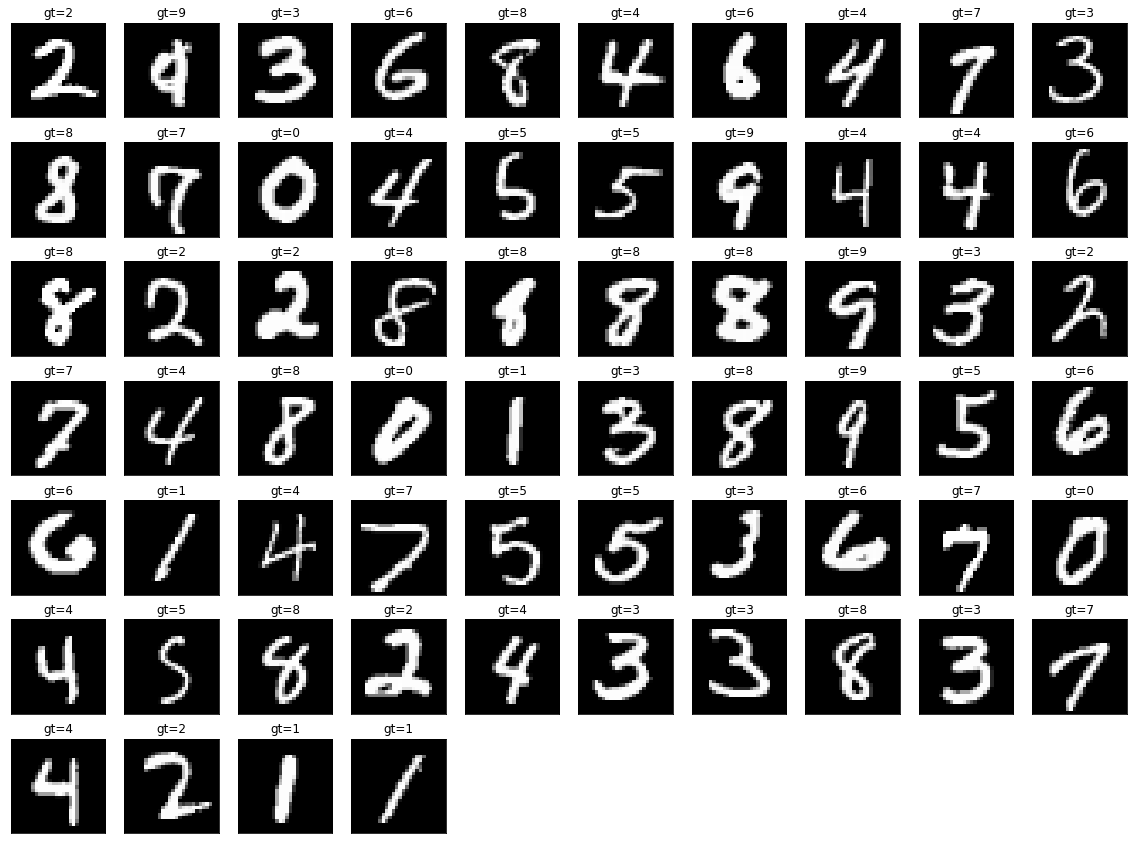

=========Validation Dataset=========


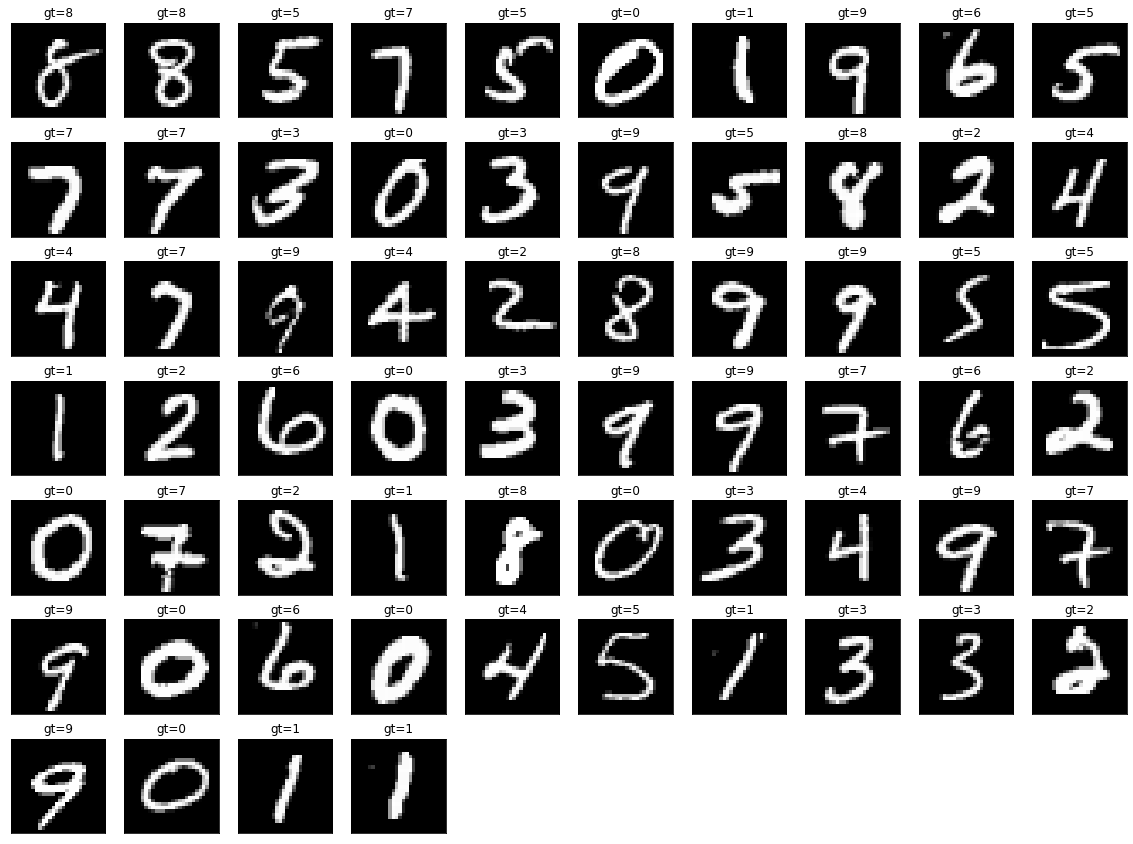

In [13]:
with tf.Session() as sess:
    for epoch in range(1):
        # iter train data
        cnt = 0
        sess.run(train_iter_init)
        print("=========Training Dataset=========")
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                if cnt % 3000 == 0:
                    visualize_batch(X_batch, y_batch)
                cnt+=1
            except tf.errors.OutOfRangeError:
                break
        
        # iter validation data
        cnt = 0
        sess.run(validation_iter_init)
        print("=========Validation Dataset=========")
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                if cnt % 1000 == 0:
                    visualize_batch(X_batch, y_batch)
                cnt+=1
            except tf.errors.OutOfRangeError:
                break

## 3. Training

In [14]:
lr = 0.01
iter_per_epoch = X_train.shape[0] // batch_size
epochs = 15
checkpoint_path = './checkpoints_1'

In [15]:
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=0)

with tf.Session() as sess:
    # Initialize global variables
    sess.run(init)
    
    not_improved_cnt = 0
    val_loss_best = 99999999
    
    # Training loop
    for epoch in range(epochs):
        start = time.time()

        train_loss_list = []
        train_acc_list = []
        validation_loss_list = []
        validation_acc_list = []
        
        # train
        sess.run(train_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                
                feed_dict={
                    X_ : X_batch,
                    y_ : y_batch,
                    lr_ : lr,
                }
                # update trainable weights
                sess.run(train_op, feed_dict=feed_dict)
                
                # calc. train loss & accuracy per batch
                train_loss, train_acc = sess.run([loss_op, accuracy_op], feed_dict=feed_dict)
                
                train_loss_list.append(train_loss)
                train_acc_list.append(train_acc)
            except tf.errors.OutOfRangeError:
                break
        
        # validation
        sess.run(validation_iter_init)
        while True:
            try:
                X_batch, y_batch = sess.run(next_data)
                # calc. validation loss & acc 
                val_loss, val_acc = sess.run([loss_op, accuracy_op], feed_dict={
                    X_ : X_batch,
                    y_ : y_batch,
                    lr_ : lr,
                })
                validation_loss_list.append(val_loss)
                validation_acc_list.append(val_acc)
            except tf.errors.OutOfRangeError:
                break
        elapsed_time = time.time() - start 
        
        # Average over dataset
        train_loss = np.average(train_loss_list)
        train_acc = np.average(train_acc_list)
        val_loss = np.average(validation_loss_list)
        val_acc = np.average(validation_acc_list)
        
        print('epoch {0}, time_per_epoch={1:.1f} s, loss={2:.4f}, acc={3:.2f}, val_loss={4:.4f}, val_acc={5:.2f}'
              .format(epoch, elapsed_time, train_loss, train_acc, val_loss, val_acc))
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            
            # reset count
            not_improved_cnt = 0
            
            saver.save(sess, '{}/model_{}.ckpt'.format(checkpoint_path, epoch))
            print('val_loss improved -- Trained Model Saved')
        else:
            not_improved_cnt += 1
            print('val_loss not improved')
            
            if not_improved_cnt >= 3:
                print('val_loss not improved -- Stop training session')
                break

epoch 0, time_per_epoch=4.0 s, loss=0.7997, acc=0.87, val_loss=0.5694, val_acc=0.85
INFO:tensorflow:./checkpoints/model_0.ckpt is not in all_model_checkpoint_paths. Manually adding it.
val_loss improved -- Trained Model Saved
epoch 1, time_per_epoch=3.0 s, loss=0.4488, acc=0.89, val_loss=0.8463, val_acc=0.84
val_loss not improved
epoch 2, time_per_epoch=3.0 s, loss=2.6574, acc=0.86, val_loss=2.0937, val_acc=0.86
val_loss not improved
epoch 3, time_per_epoch=3.0 s, loss=0.5494, acc=0.91, val_loss=0.4630, val_acc=0.90
INFO:tensorflow:./checkpoints/model_3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
val_loss improved -- Trained Model Saved
epoch 4, time_per_epoch=3.0 s, loss=0.2932, acc=0.92, val_loss=0.5231, val_acc=0.88
val_loss not improved
epoch 5, time_per_epoch=3.0 s, loss=6.8762, acc=0.88, val_loss=13.9259, val_acc=0.86
val_loss not improved
epoch 6, time_per_epoch=3.0 s, loss=2.7624, acc=0.90, val_loss=1.3624, val_acc=0.89
val_loss not improved
val_loss not impr

## 4. Test

INFO:tensorflow:Restoring parameters from checkpoints/model_3.ckpt


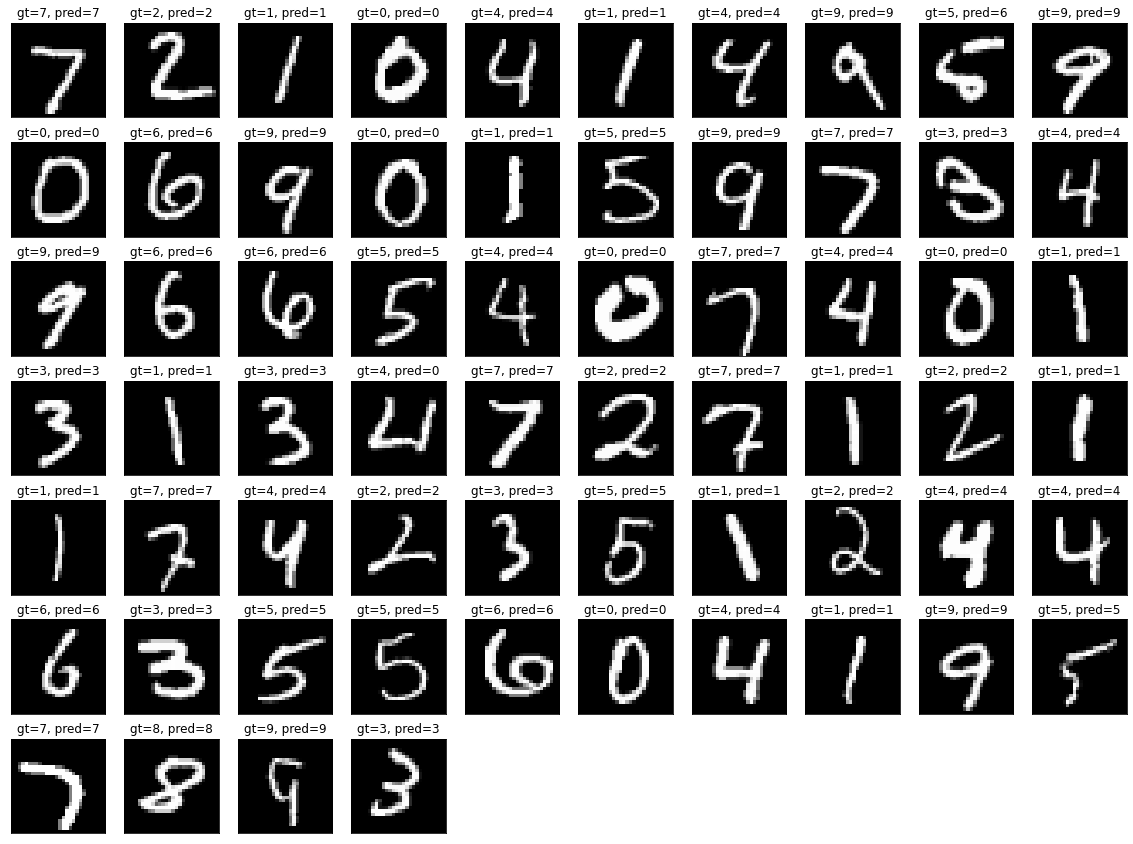

test_acc=0.938


In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(checkpoint_path))
    
    test_loss_list = []
    test_acc_list = []
    
    sess.run(test_iter_init)

    # evaluate
    cnt = 0
    while True:
        try:
            X_batch, y_batch = sess.run(next_data)
            
            # calc. test loss & acc 
            pred_labels, test_acc = sess.run([pred_label_op, accuracy_op], feed_dict={
                X_ : X_batch,
                y_ : y_batch,
                lr_ : lr,
            })
            
            if cnt % 500 == 0:
                visualize_batch(X_batch, y_batch, pred_labels)
            test_acc_list.append(test_acc)
            
            cnt += 1
        except tf.errors.OutOfRangeError:
            break
            
    test_acc = np.average(test_acc)

    print('test_acc={0:.3f}'.format(test_acc))